In [1]:
import numpy as np
import math

# Computer Experiments with Accelerated by Coupling Directional Search (ACDS) Method. Different norms

Article: https://arxiv.org/abs/1710.00162v1 (in Russian)

Let $A$ be a real random matrix $n \times n$ with elements from $[0, \, 1]$. 
$$
B = \frac{A^T A}{\lambda_{max}(A^T A)}, \quad x_* = (1, \, 0, \, 0, \, \ldots, \, 0). 
$$

Function to be minimized: $f = \frac{1}{2} \langle x - x_*, \, B(x - x_*) \rangle \, \rightarrow \, \min\limits_x$.


In [2]:
# Power iteration algorithm (eigenvalue algorithm)
def power_iteration(A, maxiter):
    
    b_k = np.random.rand(A.shape[0])
    
    for k in range(0, maxiter):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

In [3]:
n = int(1e2); # Dimension of vector space
x_star = np.zeros(n).reshape(n, 1);
x_star[0] = 1;

A = np.random.rand(n, n);
B = (A.T).dot(A);

# Find B eigenvector associated with the dominant eigenvalue
e_vect = power_iteration(B, 1000)

e_vect_tr = e_vect.reshape(1, e_vect.size)

# Rayleigh quotient
# Dominant eigenvalue of B
e_value = np.dot(e_vect_tr, np.dot(B, e_vect)) / np.dot(e_vect_tr, e_vect)

B = B / e_value
print(e_value)

[2506.35158177]


In [4]:
f = lambda x: 1 / 2 * np.dot((x - x_star).reshape(1, n), np.dot(B, x - x_star))

In [5]:
#Initial point
x0 = np.zeros(n).reshape(n, 1);
x0[n-1] = 1;

L = 1

y0 = x0
z0 = x0

f_star = f(x_star)
f_x = f(x0)

In [6]:
# Generating uniformly distributed numbers on a sphere
def get_rand_vec(dims):
    e = np.random.standard_normal(dims)
    return e / np.linalg.norm(e)

In [7]:
# Dikhotomy method for one-dimensional minimization 
def dihot(func, xa, xb, eps, maxit, a, c):
    
    fa = func(xa, a, c)
    fb = func(xb, a, c)
    if fa*fb > 0:
        print("Error - Dihotomy can't work!")
    
    iter = 0
    while abs(xb-xa) > eps and iter < maxit:  
        xc = (xa+xb) / 2
        fc = func(xc, a, c)
        #print("fc", fc)
        if fa*fc > 0:
            xa = xc
        else:
            xb = xc
            
        iter = iter + 1
    return xc

Распишем отдельно шаг метода для вычисления $z$, используя обозначения из статьи https://arxiv.org/ftp/arxiv/papers/1603/1603.07701.pdf.

Необходимо решить задачу
$$
\tilde{F}(z) = \langle c, \, z \rangle + \frac{1}{2(a-1)} \|z \|_a^2 \, \rightarrow \, \min_z
$$

С помощью метода множителей Лагранжа получаем
$$
\tilde{G}(\lambda) = \min_{t, \, z_k} \left \{ \sum_{k = 1}^n c_k z_k + \frac{1}{2(a-1)} t +  \lambda \left (\sum_{k=1}^n z_k^a - t^{a/2} \right ) \right \}.
$$


Необходимо решить задачу
$$
\max_{\lambda \, \ge \, 0} \tilde{G} (\lambda).
$$

Для этого найдем выражения для $t^*(\lambda)$ и $z_k^*(\lambda)$:
$$
t^* = \left [ \lambda a (a - 1) \right ]^{\frac{2}{2-a}}, \quad z_k^* = \left (-\frac{c_k}{\lambda a} \right )^{\frac{1}{a-1}}
$$

Пусть $\breve{G}(\lambda) = - \tilde{G}(\lambda)$. Тогда задача для решения
$$
\min_{\lambda \, \ge \, 0} \breve{G} (\lambda).
$$
При этом 
$$
\frac{\partial \breve{G}(\lambda)}{\partial \lambda} = t^*(\lambda)^{a/2} - \sum_{k=1}^n \left (z_k^*(\lambda) \right )^a
$$
Получилась задача одномерной минимизации, её можно решить простой дихотомией.

Примечание. В нашем случае $c = n \, \alpha_{k+1} \langle B x^{k+1} - x_*, \, e^{k + 1} \rangle e^{k + 1} - \nabla d(z^k)$, $d(z) = \frac{1}{2(a-1)} \| z \|_a^2$, $a = 1 + \frac{1}{2 \ln n}$.


In [8]:
# Prox-function 
# z should be a vector, not a matrix (use np.ravel() to convert)
def d(z, a):
    norm_z = np.linalg.norm(z, a)
    return 1/ 2 / (a - 1) * norm_z* norm_z

In [9]:
#Gradient of prox-function 
def grad_d(z, a):
    g = np.zeros(n).reshape(n, 1)
    norm_z = np.linalg.norm(np.ravel(z), a)
    nzz = 1/ (a - 1)*pow(norm_z, 2 - a)
    for k in range(0, n):
        g[k] = nzz * pow(abs(z[k]), a - 1)
        
    return g

In [10]:
#Gradient G(lambda) 
def grad_G(lam, a, c):
    z = np.zeros(n).reshape(n, 1)
    g = np.zeros(n).reshape(n, 1)
    
    t = pow(lam * a * (a - 1), 2 / (2 - a))
    
    sum_z = 0
    for k in range(0, n):
        z[k] = pow( abs(- c[k] / lam / a), 1 / (a - 1))
        sum_z = sum_z + pow(z[k], a)
        
    g = pow(t, a / 2) - sum_z
    return g

In [11]:
eps = 1e-4

plist = [1 + 1 / (2 * math.log(n)), 1.4, 1.6, 1.8, 1.9, 2]
plen = len(plist)
print(plist)
qlist = [x / (x - 1) for x in plist]

C_const_list = [math.sqrt(3) * min([2*q - 1, 32* math.log(n) - 8]) * pow(n, 2/q + 1) for q in qlist]
print(C_const_list)
L = 1
Vx0_list = [d(np.ravel(x_star), p) - d(np.ravel(x0), p) - grad_d(x0, p).T.dot(x_star - x0) for p in plist]
print(Vx0_list)

Nlist = []
i = 0
for x in plist:
    Nlist.append(2 * math.sqrt(int(Vx0_list[i]) * L * C_const_list[i] / eps))
    i = i + 1
print("Number of iteration (required):", Nlist)

[1.108573620475813, 1.4, 1.6, 1.8, 1.9, 2]
[8290.577586783, 14440.060758853855, 23734.644158557196, 36341.80129614106, 43797.866746060325, 51961.52422706632]
[array([[9.21034037]]), array([[2.5]]), array([[1.66666667]]), array([[1.25]]), array([[1.11111111]]), array([[1.]])]
Number of iteration (required): [54631.56533764962, 33988.30476367288, 30812.10421802263, 38127.05144442253, 41855.87975234081, 45590.141139095555]


In [12]:
import copy

k = 0

x_list = []
y_list = []
z_list = []
x_list.append(x0[:])
z_list.append(z0[:])
y_list.append(y0[:])

for i in range(1, 6):
    x_list.append(copy.deepcopy(x0))
    z_list.append(copy.deepcopy(z0))
    y_list.append(copy.deepcopy(y0))

f_y_list = [f_x for x in plist]

maxit = 3490567

plt_list = [[] for x in plist]

alpha_list = [0 for x in plist]
c_list = [0 for x in plist]
lam_list = [0 for x in plist]
bxe_list = [0 for x in plist]

while abs(f_y_list[0][0][0] - f_star) > eps and k < maxit:
    tau = 2. / (k + 2)
    
    ip = 0
    for pl in plist:
        x_list[ip] = tau * z_list[ip] + (1 - tau) * y_list[ip]
        ip = ip + 1
    
    e = get_rand_vec(n)
    
    ip = 0
    for pl in plist:    
        bxe_list[ip] = np.dot(np.dot(B, x_list[ip] - x_star).reshape(1, n), e) * e;
        y_list[ip] = x_list[ip] - 1. / L * bxe_list[ip].reshape(n, 1);
        alpha_list[ip] = (k + 2) / 2 / L / C_const_list[ip];
        c_list[ip] = alpha_list[ip]*n*bxe_list[ip].reshape(n, 1) - grad_d(z_list[ip], plist[ip])
        if plist[ip] == 2:
            lam_list[ip] = 1
        else:    
            lam_list[ip] = dihot(grad_G, eps, 50, eps/10, maxit, plist[ip], c_list[ip])
            
        f_y_list[ip] = f(y_list[ip])    
        plt_list[ip].append(abs(f_y_list[ip][0][0]))
        ip = ip + 1
        
    ip = 0
    for pl in plist:
        if plist[ip] == 2:
            for j in range(0, n):
                z_list[ip][j] = -c_list[ip][j]
        else:        
            for j in range(0, n):
                z_list[ip][j] = pow( abs(- c_list[ip][j] / lam_list[ip] / plist[ip]), 1 / (plist[ip] - 1))
        ip = ip + 1
        
    if k%5000 == 0:
        print("f_y0", f_y_list[0], k)
        print("f_y5", f_y_list[5], k)
        
    k = k + 1
print(k, f_y_list)    

f_y0 [[0.00300117]] 0
f_y5 [[0.00300117]] 0
f_y0 [[0.00220742]] 5000
f_y5 [[0.00150018]] 5000
f_y0 [[0.00064342]] 10000
f_y5 [[0.00036919]] 10000
13725 [array([[9.99362213e-05]]), array([[1.72169317e-05]]), array([[2.66480373e-05]]), array([[5.1457593e-05]]), array([[6.88415343e-05]]), array([[8.8624766e-05]])]


<IPython.core.display.Javascript object>


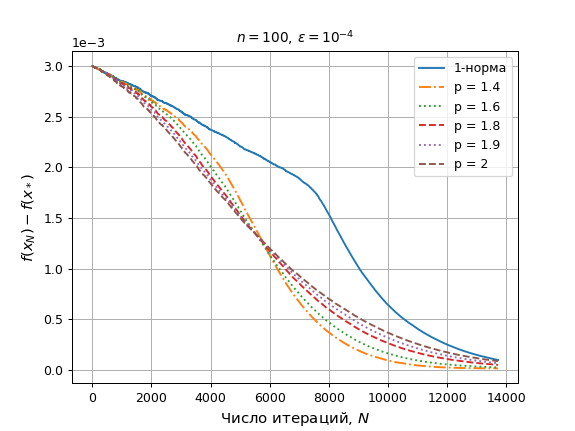

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.grid(True)
     
plt.plot(range(1, k+1), plt_list[0], label = '1-норма', linestyle = '-')
plt.plot(range(1, k+1), plt_list[1], label = 'p = 1.4', linestyle = '-.')
plt.plot(range(1, k+1), plt_list[2], label = 'p = 1.6', linestyle = ':')
plt.plot(range(1, k+1), plt_list[3], label = 'p = 1.8', linestyle = '--')
plt.plot(range(1, k+1), plt_list[4], label = 'p = 1.9', linestyle = ':')
plt.plot(range(1, k+1), plt_list[5], label = 'p = 2', linestyle = '--')


plt.xlabel(r"Число итераций, $N$", fontsize=12)
plt.ylabel(r"$f(x_N)- f(x_*) $", fontsize=12)
plt.title(r"$n = 100, \, \varepsilon = 10^{-4}$", fontsize = 11);
plt.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
plt.legend()

<IPython.core.display.Javascript object>


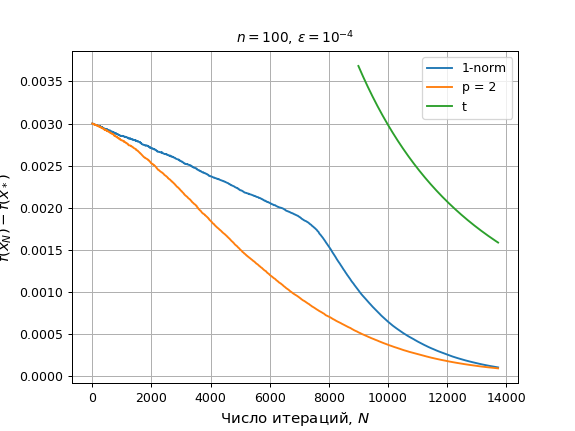

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(range(1, k+1), plt_list[0], label = '1-norm')
plt.plot(range(1, k+1), plt_list[5], label = 'p = 2')
#plt.plot(range(1, k+1), plt3, label = 'p = 1.9')

plt.plot(range(9000, k + 1), [4*int(Vx0_list[0])*C_const_list[0]*L/k/k for k in range(9000, k + 1)], label='t')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel(r"Число итераций, $N$", fontsize=12)
plt.ylabel(r"$f(x_N)- f(x_*) $", fontsize=12)
plt.title(r"$n = 100, \, \varepsilon = 10^{-4}$", fontsize = 11);
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
plt.legend()

Преимущество выбора неевклидовой нормы проявляется только при бОльших размерностях, от $n = 1000$. Из-за огромного объёма вычислений
Jupyter-блокноты для больших размерностей не создавались, все расчёты производились на обычном Python. 
Но для обработки результатов был создан отдельный блокнот, см. там же графики сравнения различных норм для $n = 1000$:
<br/>
    https://github.com/JaneJaneVL/ACDS/blob/master/plot-from-file.ipynb